In [20]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt 
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV, ShuffleSplit
from sklearn.metrics import confusion_matrix, mean_squared_error, classification_report
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier 
from sklearn.ensemble import GradientBoostingRegressor, GradientBoostingClassifier

In [2]:
data = pd.read_csv('summary_data.csv').dropna()
data.shape

(17063, 110)

In [3]:
data.head()

,file,line,start,end,speaker,speaker_role,word_count,duration,text,start_idx,...,justice_year_onset_time_diff_mean_mean,justice_year_onset_time_diff_mean_std,justice_year_onset_time_diff_stddev_mean,justice_year_onset_time_diff_stddev_std,justice_year_onset_time_diff_entropy_mean,justice_year_onset_time_diff_entropy_std,justice_year_word_rate_mean,justice_year_word_rate_std,justice_year_onset_rate_mean,justice_year_onset_rate_std
0,11-681,4,62.906,82.218,Ruth_Bader_Ginsburg,scotus_justice,45,19.312,But how does it differ from the typical bargai...,1006496,...,0.238431,0.043301,0.251816,0.063445,-62.786753,38.406475,2.141787,0.350414,5.837687,0.860461
1,11-681,6,99.497,119.410,Sonia_Sotomayor,scotus_justice,40,19.913,Is your argument dependent on this being sort ...,1591952,...,0.204729,0.037861,0.206904,0.050275,-83.509931,46.029953,2.434882,0.391229,6.390440,0.945190
2,11-681,16,201.764,227.298,Antonin_Scalia,scotus_justice,68,25.534,Suppose you have a policeman who -- who is dis...,3228224,...,0.197227,0.038226,0.185871,0.047700,-99.108423,53.589374,2.756272,0.472502,6.747949,0.930417
3,11-681,22,273.827,286.853,Antonin_Scalia,scotus_justice,50,13.026,It seems to me it's always a matter of public ...,4381232,...,0.197227,0.038226,0.185871,0.047700,-99.108423,53.589374,2.756272,0.472502,6.747949,0.930417
4,11-681,32,350.343,397.472,Elena_Kagan,scotus_justice,130,47.129,"But what -- what you're objecting to, to the e...",5605488,...,0.178505,0.027986,0.151338,0.030079,-136.943023,56.329519,2.982173,0.376701,7.209296,0.770327


In [4]:
data.columns

Index(['file', 'line', 'start', 'end', 'speaker', 'speaker_role', 'word_count',
       'duration', 'text', 'start_idx',
       ...
       'justice_year_onset_time_diff_mean_mean',
       'justice_year_onset_time_diff_mean_std',
       'justice_year_onset_time_diff_stddev_mean',
       'justice_year_onset_time_diff_stddev_std',
       'justice_year_onset_time_diff_entropy_mean',
       'justice_year_onset_time_diff_entropy_std',
       'justice_year_word_rate_mean', 'justice_year_word_rate_std',
       'justice_year_onset_rate_mean', 'justice_year_onset_rate_std'],
      dtype='object', length=110)

In [5]:
data.drop(['file', 'line', 'start', 'end', 'speaker', 'speaker_role', 'text', 
         'start_idx','end_idx'], axis=1, inplace=True)
data.shape

(17063, 101)

# Random Forest Classifier

In [7]:
df = data.copy()
df['gs_class'] = np.where(df['gs_score']>data['gs_score'].mean(),1,0)
df.drop('gs_score', axis=1, inplace=True)
print(df.shape)

(17063, 101)


In [8]:
X = df.loc[:, df.columns != 'gs_class']
y = df.loc[:, df.columns == 'gs_class']

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2020)
print(len(X_train))
print(len(X_test))

13650
3413


In [10]:
cv = []
ss = ShuffleSplit(n_splits=3, test_size=0.2, random_state=2020)
for trainIdx, valIdx in ss.split(X_train, y_train):
    cv.append((trainIdx, valIdx))

In [11]:
pipe = Pipeline(steps = [('scaler', StandardScaler()), ('rfc', RandomForestClassifier())])
parameters = {'rfc__n_estimators':[20, 50, 100, 200, 500, 1000], \
              'rfc__max_depth':[2,5,10,20,None], \
              'rfc__min_samples_leaf': [1, 2, 4], \
              'rfc__min_samples_split': [2, 5, 10], \
              'rfc__max_features': ['auto', 'sqrt', 'log2'], \
              'rfc__random_state':[2020]}

In [ ]:
clf = GridSearchCV(pipe, parameters, scoring='accuracy', verbose=1)
clf.fit(X_train, y_train.values.ravel())

In [ ]:
print(clf.best_params_)
print(clf.best_score_)
print(clf.best_estimator_.steps)

In [ ]:
preds = clf.predict(X_test)
pred_df = pd.DataFrame(data={"y_true":y_test, "y_pred": preds})

pred_df = pred_df.sort_values('y_true').reset_index(drop = True)
pred_df = pred_df.reset_index(drop = False)

figure, ax = plt.subplots(ncols = 1, figsize = (12,6))
g = sns.scatterplot(x = 'index', y = 'y_true', data = pred_df, alpha = 1, label = 'Y_True', color = 'k')
g = sns.scatterplot(x = 'index', y = 'y_pred', data = pred_df, alpha = .35, label = 'Y_Pred', color = 'red')
plt.title('Actual vs Predictions')
plt.ylabel('Grandstanding Score')
plt.show()

# Random Forest Regression

In [6]:
df = data.copy()
df.shape

(17063, 101)

In [7]:
X = df.loc[:, df.columns != 'gs_score']
y = df.loc[:, df.columns == 'gs_score']

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2020)
print(len(X_train))
print(len(X_test))

13650
3413


In [9]:
cv = []
ss = ShuffleSplit(n_splits=3, test_size=0.2, random_state=2020)
for trainIdx, valIdx in ss.split(X_train, y_train):
    cv.append((trainIdx, valIdx))

In [34]:
pipe = Pipeline(steps = [('scaler', StandardScaler()), ('rfr', RandomForestRegressor())])
parameters = {'rfr__n_estimators':[20, 50, 100, 200, 500, 1000], \
              'rfr__max_depth':[2,5,10,20,None], \
              'rfr__random_state':[2020]}
# parameters = {'rfr__n_estimators':[20, 50, 100], \
#               'rfr__max_depth':[2,5,10], \
#               'rfr__random_state':[2020]}

In [35]:
clf = GridSearchCV(pipe, parameters, scoring='neg_mean_squared_error', verbose=2)
clf.fit(X_train, y_train.values.ravel())

Fitting 5 folds for each of 30 candidates, totalling 150 fits
[CV] END rfr__max_depth=2, rfr__n_estimators=20, rfr__random_state=2020; total time=   0.7s
[CV] END rfr__max_depth=2, rfr__n_estimators=20, rfr__random_state=2020; total time=   0.7s
[CV] END rfr__max_depth=2, rfr__n_estimators=20, rfr__random_state=2020; total time=   0.7s
[CV] END rfr__max_depth=2, rfr__n_estimators=20, rfr__random_state=2020; total time=   0.7s
[CV] END rfr__max_depth=2, rfr__n_estimators=20, rfr__random_state=2020; total time=   0.7s
[CV] END rfr__max_depth=2, rfr__n_estimators=50, rfr__random_state=2020; total time=   1.7s
[CV] END rfr__max_depth=2, rfr__n_estimators=50, rfr__random_state=2020; total time=   1.6s
[CV] END rfr__max_depth=2, rfr__n_estimators=50, rfr__random_state=2020; total time=   1.6s
[CV] END rfr__max_depth=2, rfr__n_estimators=50, rfr__random_state=2020; total time=   1.7s
[CV] END rfr__max_depth=2, rfr__n_estimators=50, rfr__random_state=2020; total time=   1.7s
[CV] END rfr__max_

[CV] END rfr__max_depth=10, rfr__n_estimators=1000, rfr__random_state=2020; total time= 2.6min
[CV] END rfr__max_depth=10, rfr__n_estimators=1000, rfr__random_state=2020; total time= 2.6min
[CV] END rfr__max_depth=20, rfr__n_estimators=20, rfr__random_state=2020; total time=   4.9s
[CV] END rfr__max_depth=20, rfr__n_estimators=20, rfr__random_state=2020; total time=   5.0s
[CV] END rfr__max_depth=20, rfr__n_estimators=20, rfr__random_state=2020; total time=   5.4s
[CV] END rfr__max_depth=20, rfr__n_estimators=20, rfr__random_state=2020; total time=   5.0s
[CV] END rfr__max_depth=20, rfr__n_estimators=20, rfr__random_state=2020; total time=   4.9s
[CV] END rfr__max_depth=20, rfr__n_estimators=50, rfr__random_state=2020; total time=  12.6s
[CV] END rfr__max_depth=20, rfr__n_estimators=50, rfr__random_state=2020; total time=  13.6s
[CV] END rfr__max_depth=20, rfr__n_estimators=50, rfr__random_state=2020; total time=  13.2s
[CV] END rfr__max_depth=20, rfr__n_estimators=50, rfr__random_stat

GridSearchCV(estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('rfr', RandomForestRegressor())]),
             param_grid={'rfr__max_depth': [2, 5, 10, 20, None],
                         'rfr__n_estimators': [20, 50, 100, 200, 500, 1000],
                         'rfr__random_state': [2020]},
             scoring='neg_mean_squared_error', verbose=2)

In [36]:
print(clf.best_params_)
print(clf.best_score_)
print(clf.best_estimator_.steps)

{'rfr__max_depth': 10, 'rfr__n_estimators': 1000, 'rfr__random_state': 2020}
-0.3049617558679257
[('scaler', StandardScaler()), ('rfr', RandomForestRegressor(max_depth=10, n_estimators=1000, random_state=2020))]


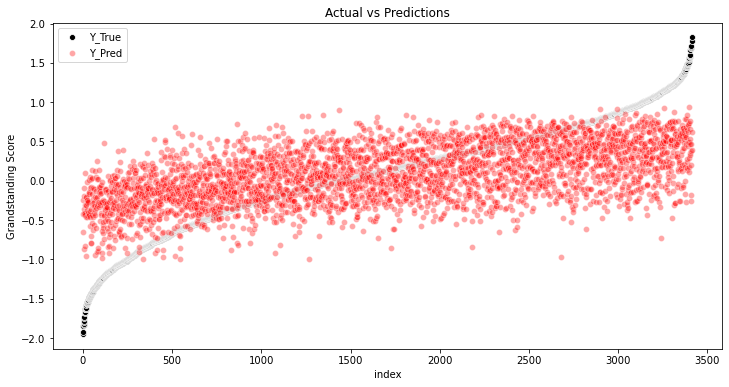

In [37]:
preds = clf.predict(X_test)
pred_df = pd.DataFrame(data={"y_true":y_test.values.ravel(), "y_pred": preds})

pred_df = pred_df.sort_values('y_true').reset_index(drop = True)
pred_df = pred_df.reset_index(drop = False)

figure, ax = plt.subplots(ncols = 1, figsize = (12,6))
g = sns.scatterplot(x = 'index', y = 'y_true', data = pred_df, alpha = 1, label = 'Y_True', color = 'k')
g = sns.scatterplot(x = 'index', y = 'y_pred', data = pred_df, alpha = .35, label = 'Y_Pred', color = 'red')
plt.title('Actual vs Predictions')
plt.ylabel('Grandstanding Score')
plt.show()

In [38]:
clf = GridSearchCV(pipe, parameters, scoring='r2', verbose=2)
clf.fit(X_train, y_train.values.ravel())

Fitting 5 folds for each of 30 candidates, totalling 150 fits
[CV] END rfr__max_depth=2, rfr__n_estimators=20, rfr__random_state=2020; total time=   0.7s
[CV] END rfr__max_depth=2, rfr__n_estimators=20, rfr__random_state=2020; total time=   0.7s
[CV] END rfr__max_depth=2, rfr__n_estimators=20, rfr__random_state=2020; total time=   0.8s
[CV] END rfr__max_depth=2, rfr__n_estimators=20, rfr__random_state=2020; total time=   0.7s
[CV] END rfr__max_depth=2, rfr__n_estimators=20, rfr__random_state=2020; total time=   0.8s
[CV] END rfr__max_depth=2, rfr__n_estimators=50, rfr__random_state=2020; total time=   1.8s
[CV] END rfr__max_depth=2, rfr__n_estimators=50, rfr__random_state=2020; total time=   1.7s
[CV] END rfr__max_depth=2, rfr__n_estimators=50, rfr__random_state=2020; total time=   1.7s
[CV] END rfr__max_depth=2, rfr__n_estimators=50, rfr__random_state=2020; total time=   1.7s
[CV] END rfr__max_depth=2, rfr__n_estimators=50, rfr__random_state=2020; total time=   1.7s
[CV] END rfr__max_

[CV] END rfr__max_depth=10, rfr__n_estimators=1000, rfr__random_state=2020; total time= 2.6min
[CV] END rfr__max_depth=10, rfr__n_estimators=1000, rfr__random_state=2020; total time= 2.6min
[CV] END rfr__max_depth=20, rfr__n_estimators=20, rfr__random_state=2020; total time=   5.0s
[CV] END rfr__max_depth=20, rfr__n_estimators=20, rfr__random_state=2020; total time=   4.9s
[CV] END rfr__max_depth=20, rfr__n_estimators=20, rfr__random_state=2020; total time=   5.1s
[CV] END rfr__max_depth=20, rfr__n_estimators=20, rfr__random_state=2020; total time=   5.2s
[CV] END rfr__max_depth=20, rfr__n_estimators=20, rfr__random_state=2020; total time=   5.1s
[CV] END rfr__max_depth=20, rfr__n_estimators=50, rfr__random_state=2020; total time=  12.3s
[CV] END rfr__max_depth=20, rfr__n_estimators=50, rfr__random_state=2020; total time=  12.2s
[CV] END rfr__max_depth=20, rfr__n_estimators=50, rfr__random_state=2020; total time=  12.3s
[CV] END rfr__max_depth=20, rfr__n_estimators=50, rfr__random_stat

GridSearchCV(estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('rfr', RandomForestRegressor())]),
             param_grid={'rfr__max_depth': [2, 5, 10, 20, None],
                         'rfr__n_estimators': [20, 50, 100, 200, 500, 1000],
                         'rfr__random_state': [2020]},
             scoring='r2', verbose=2)

In [39]:
print(clf.best_params_)
print(clf.best_score_)
print(clf.best_estimator_.steps)

{'rfr__max_depth': 10, 'rfr__n_estimators': 1000, 'rfr__random_state': 2020}
0.29546607751077525
[('scaler', StandardScaler()), ('rfr', RandomForestRegressor(max_depth=10, n_estimators=1000, random_state=2020))]


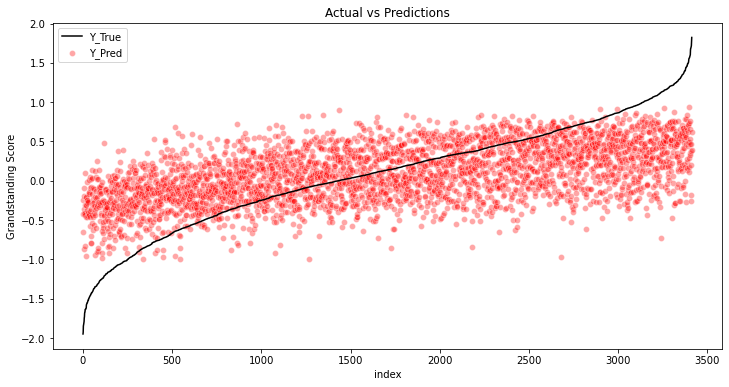

In [40]:
preds = clf.predict(X_test)
pred_df = pd.DataFrame(data={"y_true":y_test.values.ravel(), "y_pred": preds})

pred_df = pred_df.sort_values('y_true').reset_index(drop = True)
pred_df = pred_df.reset_index(drop = False)

figure, ax = plt.subplots(ncols = 1, figsize = (12,6))
g = sns.lineplot(x = 'index', y = 'y_true', data = pred_df, alpha = 1, label = 'Y_True', color = 'k')
g = sns.scatterplot(x = 'index', y = 'y_pred', data = pred_df, alpha = .35, label = 'Y_Pred', color = 'red')
plt.title('Actual vs Predictions')
plt.ylabel('Grandstanding Score')
plt.show()